In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
prices.head(1)

,달러,나스닥100,다우
Date,,,
2001-01-02,1278.000,11660.355,5042.930


<AxesSubplot:xlabel='Date'>

                 달러    나스닥100        다우     나스닥100_1      다우_1
Date                                                          
2001-01-02 1278.000 11660.355  5042.930  2720580.840 44487.180
2001-01-03 1270.500 13767.882  5154.618  3212306.790 44708.895
2001-01-04 1263.300 13319.834  5110.000  3107768.532 46502.073
2001-01-05 1262.500 12271.450  4989.785  2863160.625 43871.875
2001-01-06 1262.500 12271.450  4989.785  2863160.625 43871.875
...             ...       ...       ...          ...       ...
2020-06-28 1203.800 54285.000 15374.000 11856659.568 47911.240
2020-06-29 1199.160 52844.000 14994.000 11945024.626 49141.577
2020-06-30 1199.280 53676.000 15240.000 12180907.068 48882.653
2020-07-01 1201.510 54445.000 15270.000 12350621.668 48961.533
2020-07-02 1198.750 55322.000 15319.000 12397340.637 49856.013

[7122 rows x 5 columns]


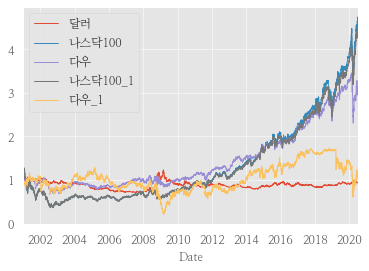

In [4]:
p = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
df = prices.copy()
df['나스닥100_1'] = p['나스닥100']*prices['달러']
df['다우_1'] = p['다우']*prices['달러']

df.dropna().rebase(1).plot();
print(df)

In [5]:
data = pd.read_csv("/Users/hosung/workspace/git/docu/data/asset_db.csv", index_col=0, parse_dates=True)
data.sample()

,kbond20y,vn30,kbond1y,uscorp15_UH,usenergy_UH,usdkrw,usbond30y_H,kbond10y,eurkrw,em_H,topx100,nasdaq100_H,cnykrw,world_UH,csi300,us500_UH,dji_UH,gold_H,kodex200x2,jpykrw,nasdaq100_UH,reit_H,kbond3y,kodex200,copper_UH,us500_H,usbond10y_UH,usdkrwx2,us500_Hx2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-11-04,124486.000,10025.000,97014.000,81186.614,8820.000,1141.450,10675.210,113679.000,1271.690,8700.000,10790.000,6410.224,168.940,9965.000,6997.000,5549.507,9640.000,9925.000,10520.000,11.067,23842.000,10101.000,104094.000,22783.000,5505.000,24580.000,10718.764,8989.158,9735.000


<AxesSubplot:xlabel='Date'>

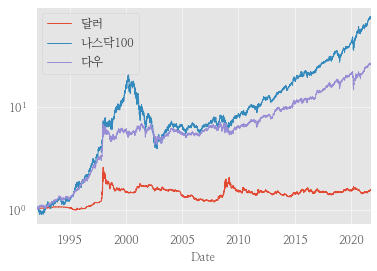

In [6]:
prices = data[['usdkrw', 'nasdaq100_UH', 'dji_UH']].copy()
prices.columns = ['달러','나스닥100','다우']
prices = prices.resample('D').first().fillna(method="ffill")
prices.dropna().rebase(1).plot(logy=True)
prices = prices['2001-01-02':'2020-07-02']
prices.to_csv("dollar_assets.csv")

In [7]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

In [8]:
target_weights = pd.DataFrame()
for c in ["나스닥100", "다우", "달러"]:
    target_weights[c] = prices[c].rolling(365).apply(AMS)
target_weights = target_weights*0.5
# target_weights['현금'] = 1.0 - target_weights.sum(axis=1)

In [9]:
target_weights.sum(axis=1)

Date
2001-01-02   0.000
2001-01-03   0.000
2001-01-04   0.000
2001-01-05   0.000
2001-01-06   0.000
              ... 
2020-06-28   0.923
2020-06-29   0.863
2020-06-30   0.880
2020-07-01   0.904
2020-07-02   0.893
Freq: D, Length: 7122, dtype: float64

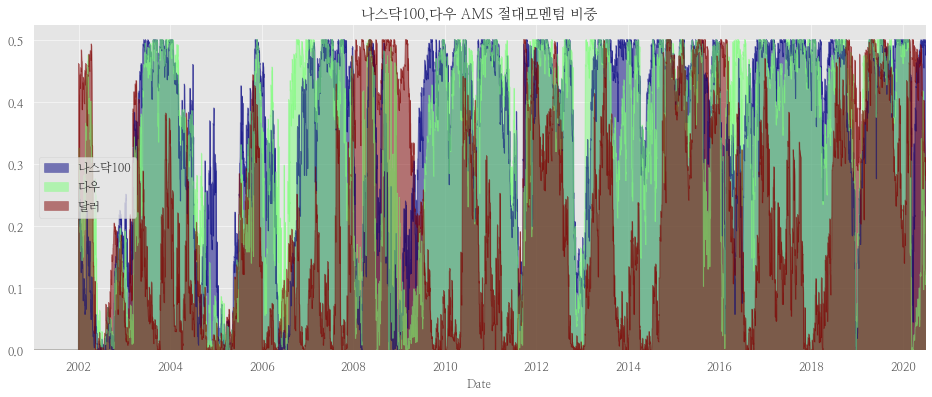

In [10]:
target_weights[['나스닥100', '다우', '달러']].plot.area(stacked=False, alpha=0.5, cmap='jet',
    figsize=(16,6), title='나스닥100,다우 AMS 절대모멘텀 비중', legend=True);

In [11]:
tickers = prices.columns
tickers

Index(['달러', '나스닥100', '다우'], dtype='object')

In [21]:
나스닥다우동일비중 =bt.Strategy(
    "나스닥다우동일비중",
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우']),
        bt.algos.WeighEqually(),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [13]:
나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [14]:
def long_only_ew(data, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate('2002-02-01'),
                           bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [22]:
bt_나스닥다우동일비중 = bt.Backtest(나스닥다우동일비중, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS,  prices)
bt_나스닥 = long_only_ew(prices[['나스닥100']], '나스닥100')
bt_다우 = long_only_ew(prices[['다우']], '다우')
bt_달러 = long_only_ew(prices[['달러']], '달러')
r = bt.run(bt_나스닥다우동일비중, bt_나스닥다우동일비중AMS, bt_나스닥, bt_다우, bt_달러)

In [23]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 나스닥다우동일비중    나스닥다우동일비중AMS    나스닥100    다우        달러
-------------------  --------------------  -----------------------  -----------  ----------  ----------
Start                2002-02-01            2002-02-01               2002-02-01   2002-02-01  2002-02-01
End                  2020-07-02            2020-07-02               2020-07-02   2020-07-02  2020-07-02
Risk-free rate       0.00%                 0.00%                    0.00%        0.00%       0.00%

Total Return         356.85%               172.38%                  543.46%      212.88%     -8.67%
Daily Sharpe         0.43                  0.39                     0.45         0.35        0.01
Daily Sortino        0.67                  0.58                     0.72         0.54        0.01
CAGR                 8.60%                 5.59%                    10.64%       6.39%       -0.49%
Max Drawdown         -42.81%               -19.08%                  -51.22%      -35.94%     -35.74%
Calmar Ratio      

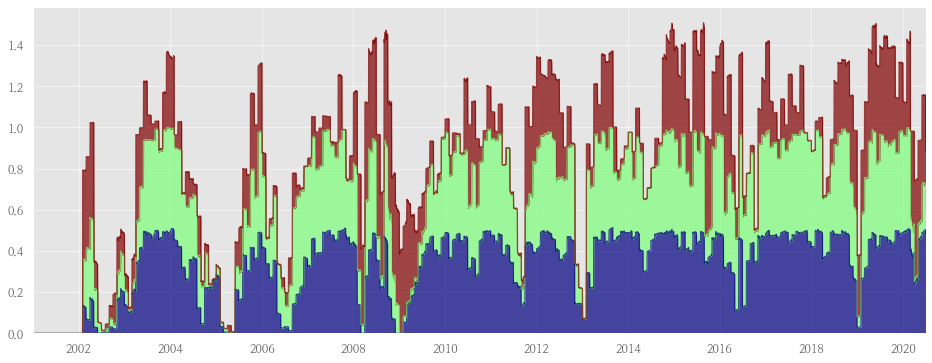

In [24]:
r.get_security_weights('나스닥다우동일비중AMS').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

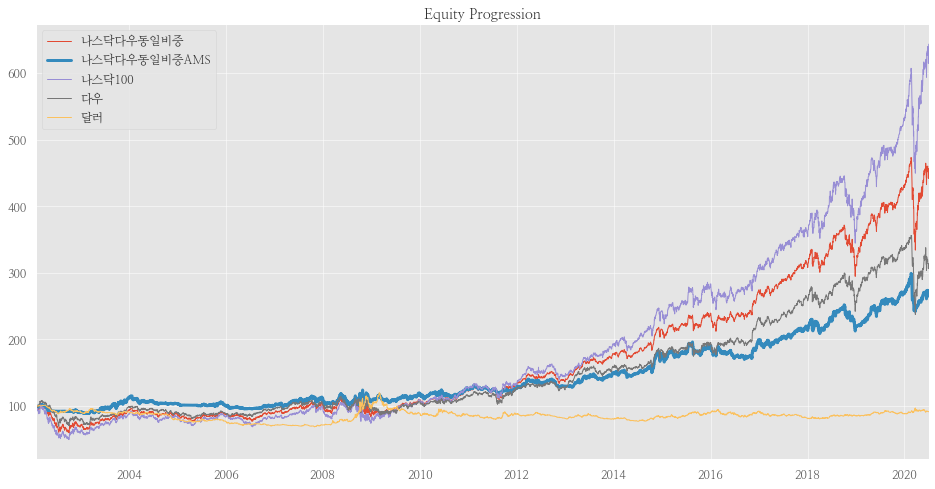

In [26]:
ax = r.plot(figsize=(16,8));
for line in ax.get_lines():
    if line.get_label() == '나스닥다우동일비중AMS':
        line.set_linewidth(3)

plt.legend(loc="upper left");

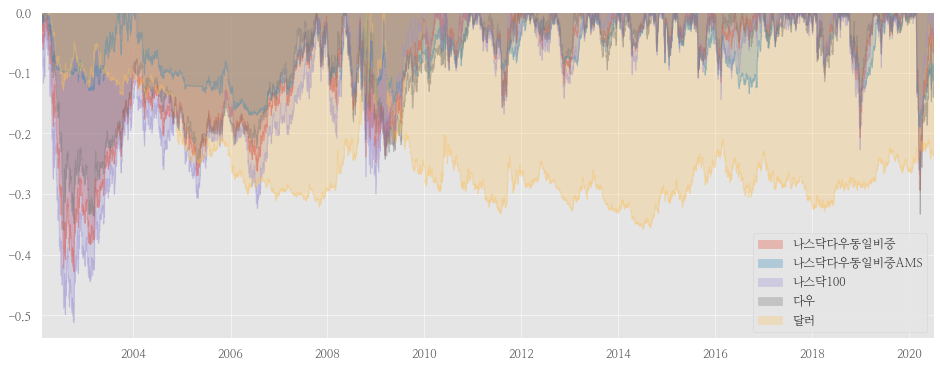

In [27]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             69.0%       68.0%

Cumulative Return          172.38%     356.85%
CAGR﹪                     5.59%       8.59%

Sharpe                     0.39        0.43
Smart Sharpe               0.35        0.38
Sortino                    0.55        0.62
Smart Sortino              0.49        0.56
Sortino/√2                 0.39        0.44
Smart Sortino/√2           0.35        0.39
Omega                      1.1         1.1

Max Drawdown               -19.08%     -42.81%
Longest DD Days            1571        2037
Volatility (ann.)          11.38%      16.53%
R^2                        0.66        0.66
Calmar                     0.29        0.2
Skew                       0.54        0.75
Kurtosis                   54.9        22.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-21,2020-03-23,2020-07-02,132,-19.082,-18.480
2,2004-01-19,2006-05-23,2008-05-08,1571,-16.994,-16.827
3,2008-10-09,2008-10-15,2008-10-28,19,-16.018,-14.403
4,2018-10-05,2018-12-26,2019-07-05,273,-15.634,-13.264
5,2008-10-29,2008-10-30,2010-06-15,594,-15.630,-14.737


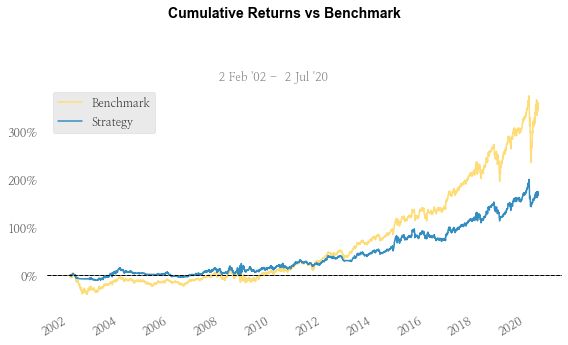

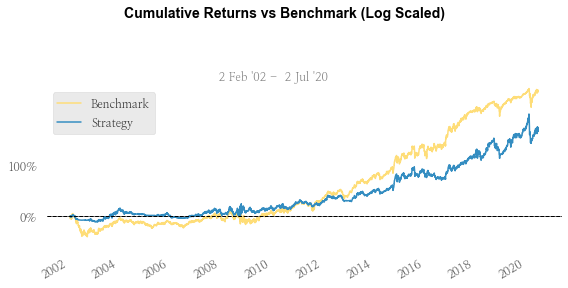

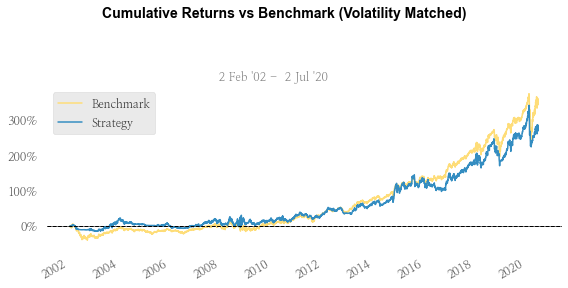

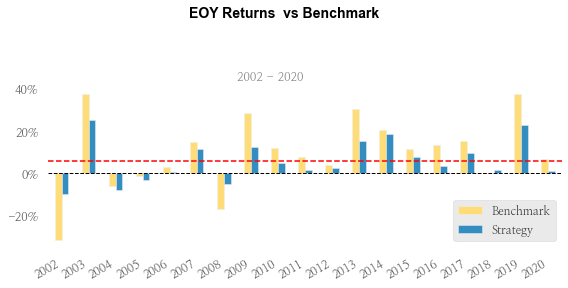

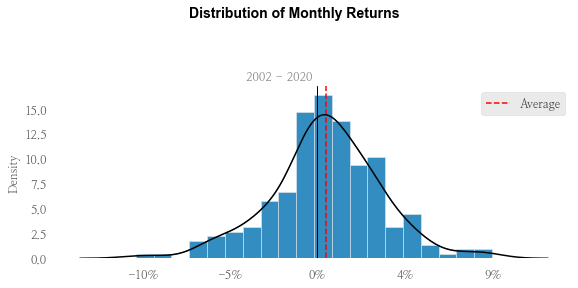

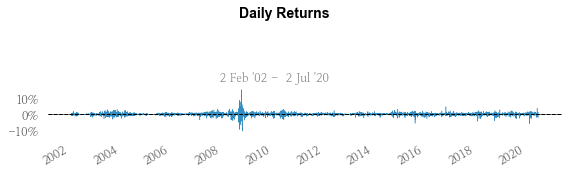

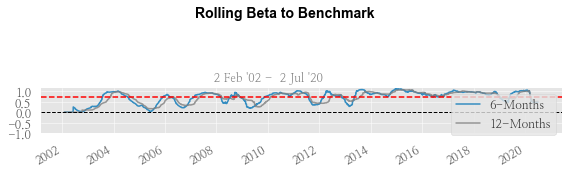

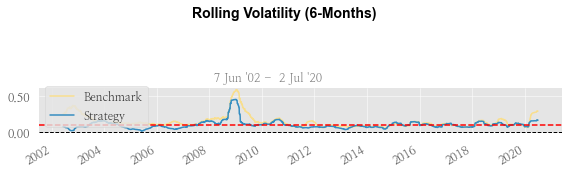

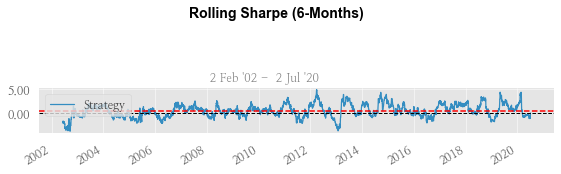

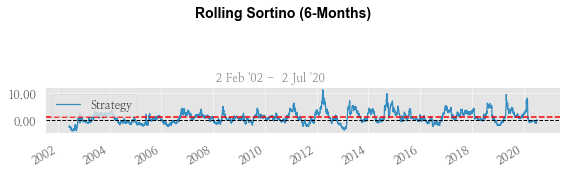

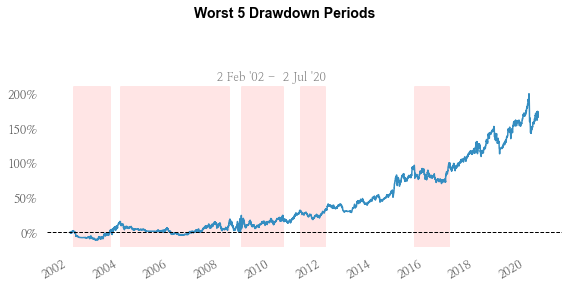

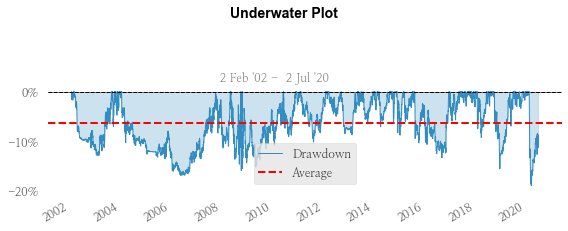

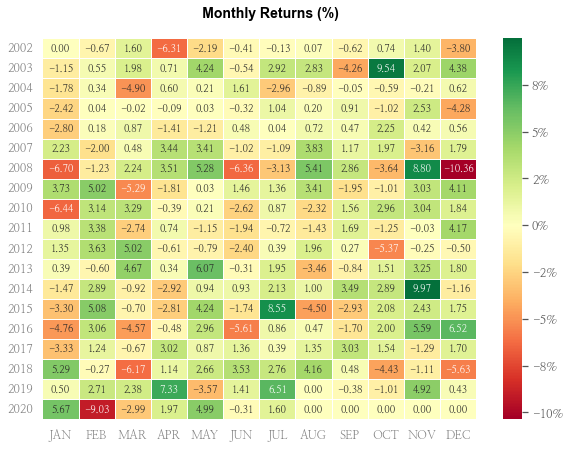

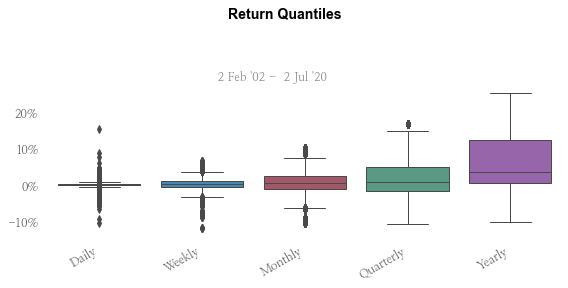

In [28]:
qs.reports.full(r['나스닥다우동일비중AMS'].prices.to_returns().dropna(), 
                r['나스닥다우동일비중'].prices.to_returns().dropna())

2020-07-02 00:00:00


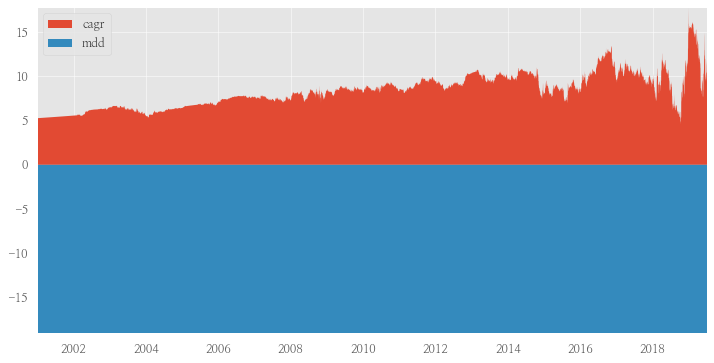

In [30]:
투자시점별CAGRMDD(bt_나스닥다우동일비중AMS)